<a href="https://colab.research.google.com/github/Lou-kku/Machine-Learning-Programming/blob/main/4%EC%A3%BC%EC%B0%A8/mHealth_1dcnn_slidingfix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
mHealth 데이터셋 분석 - 1D CNN 모델 (피실험자 단위 분할 적용)

이 스크립트는 mHealth 데이터셋을 분석하며, 데이터 유출을 방지하기 위해
'피실험자(Subject)' 단위로 훈련/검증/테스트 세트를 분할합니다.

올바른 접근 순서:
1.  데이터 로딩 및 통합
2.  ⭐ 피실험자 그룹 정의 및 데이터 분리 (Train/Validation/Test)
3.  ⭐ 각 그룹별로 슬라이딩 윈도우 적용
4.  피처 스케일링 (훈련 그룹 기준)
5.  1D CNN 모델 구축 및 학습
6.  모델 평가 및 결과 시각화
"""

In [2]:
# 1. 라이브러리 임포트 (이전과 동일)
import os
import glob
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

# 재현성을 위한 시드 설정
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# 2. 데이터 로딩 및 슬라이딩 윈도우 함수
def load_and_combine_data(data_path='/content/drive/MyDrive/mhealth'):

    log_files = glob.glob(os.path.join(data_path, 'mHealth_subject*.log'))
    all_df_list = []
    column_names = [
        'acc_chest_x', 'acc_chest_y', 'acc_chest_z', 'ecg_lead1', 'ecg_lead2',
        'acc_ankle_x', 'acc_ankle_y', 'acc_ankle_z', 'gyro_ankle_x', 'gyro_ankle_y', 'gyro_ankle_z',
        'mag_ankle_x', 'mag_ankle_y', 'mag_ankle_z', 'acc_arm_x', 'acc_arm_y', 'acc_arm_z',
        'gyro_arm_x', 'gyro_arm_y', 'gyro_arm_z', 'mag_arm_x', 'mag_arm_y', 'mag_arm_z', 'label'
    ]
    for file in log_files:
        subject_id = int(os.path.basename(file).split('subject')[1].split('.')[0])
        df = pd.read_csv(file, header=None, sep='\t', names=column_names)
        df['subject'] = subject_id
        all_df_list.append(df)
    combined_df = pd.concat(all_df_list, ignore_index=True)
    return combined_df

def create_sequences(X, y, time_steps, step):

    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels, keepdims=True)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

# --- 데이터 처리 및 모델링 ---
# 데이터 로딩 및 기본 전처리
print("--- 데이터 로딩 및 통합 ---")
df = load_and_combine_data()
df_cleaned = df[df['label'] != 0].copy()
df_cleaned['label'] = df_cleaned['label'] - 1
print("데이터 로딩 및 기본 전처리 완료.\n")

--- 데이터 로딩 및 통합 ---
데이터 로딩 및 기본 전처리 완료.



In [5]:
# ⭐ --- 1. 피실험자(Subject) 기준으로 데이터 분할 --- ⭐
# 훈련: 6명, 검증: 2명, 테스트: 2명으로 분할
train_subjects = [1, 2, 3, 4, 5, 6]
val_subjects = [7, 8]
test_subjects = [9, 10]

df_train = df_cleaned[df_cleaned['subject'].isin(train_subjects)]
df_val = df_cleaned[df_cleaned['subject'].isin(val_subjects)]
df_test = df_cleaned[df_cleaned['subject'].isin(test_subjects)]

print(f"훈련 데이터 피실험자: {train_subjects} ({len(df_train)} rows)")
print(f"검증 데이터 피실험자: {val_subjects} ({len(df_val)} rows)")
print(f"테스트 데이터 피실험자: {test_subjects} ({len(df_test)} rows)\n")

훈련 데이터 피실험자: [1, 2, 3, 4, 5, 6] (207566 rows)
검증 데이터 피실험자: [7, 8] (67585 rows)
테스트 데이터 피실험자: [9, 10] (68044 rows)



In [6]:
# ⭐ --- 2. 각 그룹별로 피처와 레이블 분리 --- ⭐
X_train_df = df_train.drop(['subject', 'label'], axis=1)
y_train_df = df_train['label']
X_val_df = df_val.drop(['subject', 'label'], axis=1)
y_val_df = df_val['label']
X_test_df = df_test.drop(['subject', 'label'], axis=1)
y_test_df = df_test['label']

In [7]:
# ⭐ --- 3. 각 그룹별로 슬라이딩 윈도우 적용 --- ⭐
WINDOW_SIZE = 128
STEP = 64
X_train, y_train = create_sequences(X_train_df, y_train_df, WINDOW_SIZE, STEP)
X_val, y_val = create_sequences(X_val_df, y_val_df, WINDOW_SIZE, STEP)
X_test, y_test = create_sequences(X_test_df, y_test_df, WINDOW_SIZE, STEP)

print("--- 슬라이딩 윈도우 적용 후 데이터 형태 ---")
print(f"훈련 데이터: {X_train.shape}, {y_train.shape}")
print(f"검증 데이터: {X_val.shape}, {y_val.shape}")
print(f"테스트 데이터: {X_test.shape}, {y_test.shape}\n")

--- 슬라이딩 윈도우 적용 후 데이터 형태 ---
훈련 데이터: (3242, 128, 23), (3242, 1)
검증 데이터: (1055, 128, 23), (1055, 1)
테스트 데이터: (1062, 128, 23), (1062, 1)



In [8]:
# 4. 피처 스케일링 (이전과 동일하나, 분리된 데이터에 적용)
print("--- 피처 스케일링 (Standardization) ---")
# 3D 데이터를 2D로 변환
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
# 훈련 데이터 기준으로 스케일러 학습 및 변환
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
# 검증 및 테스트 데이터는 학습된 스케일러로 변환만 수행
X_val = scaler.transform(X_val_reshaped).reshape(X_val.shape)
X_test = scaler.transform(X_test_reshaped).reshape(X_test.shape)
print("피처 스케일링 완료.\n")

--- 피처 스케일링 (Standardization) ---
피처 스케일링 완료.



In [10]:
# 5. 1D CNN 모델 구축
print("--- 1D CNN 모델 구축 ---")
N_FEATURES = X_train.shape[2]
N_CLASSES = len(np.unique(df_cleaned['label']))
INPUT_SHAPE = (WINDOW_SIZE, N_FEATURES)

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(N_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

--- 1D CNN 모델 구축 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       516,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,252 (1.99 MB)

 Trainable params: 522,252 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 6. 모델 학습
print("\n--- 1D CNN 모델 학습 ---")
EPOCHS = 20
BATCH_SIZE = 64
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)


--- 1D CNN 모델 학습 ---
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6688 - loss: 1.0739 - val_accuracy: 0.6379 - val_loss: 1.1463
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9749 - loss: 0.0788 - val_accuracy: 0.7081 - val_loss: 1.0223
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9902 - loss: 0.0327 - val_accuracy: 0.6711 - val_loss: 1.0867
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9922 - loss: 0.0232 - val_accuracy: 0.6758 - val_loss: 1.0151
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9967 - loss: 0.0121 - val_accuracy: 0.6512 - val_loss: 1.1030
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9967 - loss: 0.0087 - val_accuracy: 0.6427 - val_loss: 1.0961
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9991 - loss: 0.0046 - val_accuracy: 0.6389 - val_loss: 1.1863


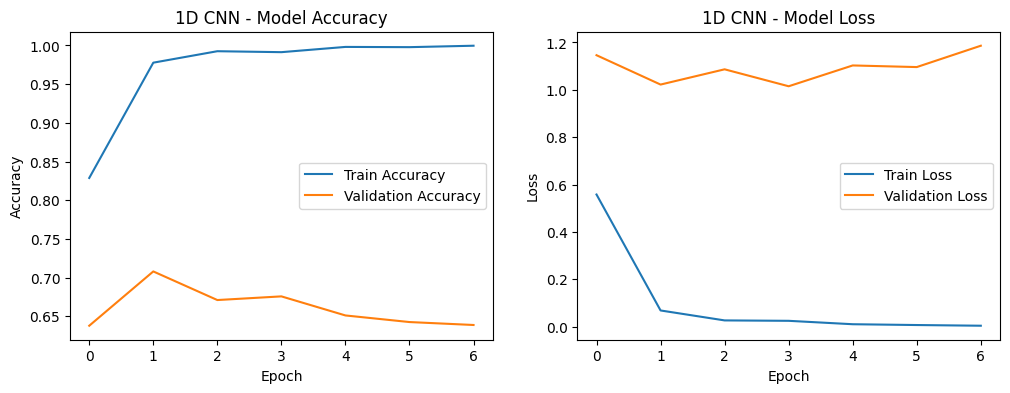

In [12]:
# 7. 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('1D CNN - Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('1D CNN - Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# 8. 모델 평가
print("\n--- 1D CNN 모델 평가 ---")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

activity_labels = [
    "Standing still", "Sitting and relaxing", "Lying down", "Walking",
    "Climbing stairs", "Waist bends forward", "Frontal elevation of arms",
    "Knees bending (crouching)", "Cycling", "Jogging", "Running", "Jump front & back"
]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=activity_labels))


--- 1D CNN 모델 평가 ---
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
                           precision    recall  f1-score   support

           Standing still       0.98      0.96      0.97        97
     Sitting and relaxing       0.65      1.00      0.79        96
               Lying down       1.00      0.99      0.99        96
                  Walking       1.00      0.99      0.99        96
          Climbing stairs       0.89      0.99      0.94        94
      Waist bends forward       0.83      0.99      0.90        83
Frontal elevation of arms       0.97      0.40      0.56        88
Knees bending (crouching)       0.99      0.74      0.84        91
                  Cycling       0.93      1.00      0.96        96
                  Jogging       1.00      0.99      0.99        96
                  Running       0.99      1.00      0.99        96
        Jump front & back       0.96      0.82      0.89        33

                 accuracy                 

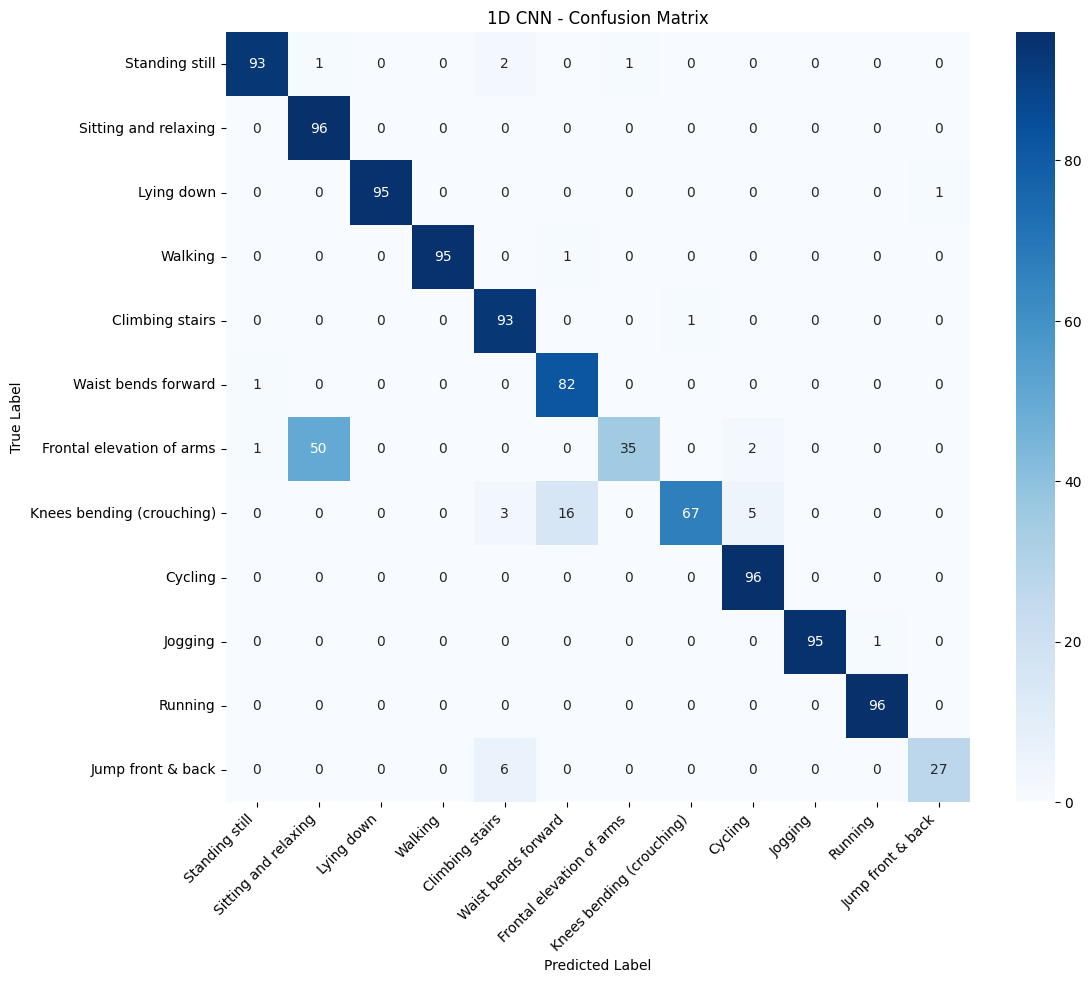

In [14]:
# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=activity_labels, yticklabels=activity_labels)
plt.title('1D CNN - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()